## Import Required Libraries

In [20]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import contextily as ctx
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
import folium
import matplotlib.ticker as ticker
import scipy.stats
import webbrowser
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from IPython.display import display, HTML, Image
import json
from scipy import stats
%matplotlib inline
import dataframe_image as dfi
import mgwr
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
import pysal
from pysal.model import spreg
import textwrap
import matplotlib.colors as colors

## Prepare the Datasets

In [21]:
# read in the Re-ordered Oxfordshire PPFI (V2) data
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/PPFI - Index Data/PPFI V2 Ox Reordered.xlsx"
ppfi_Ox_Reordered = pd.read_excel(file_path)

# read in the Geographic Lookup Table (full lookup)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/Lookup Table & Re-ordered PPFI/Full Lookup.xlsx"
full_lookup = pd.read_excel(file_path)

# read in the Oxfordshire Ward-Level Child Obesity RY data
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Storyline Data/Health Outcomes in Oxfordshire - Overview/Oxfordshire Ward Level Data/Cleaned - Oxfordshire Ward Level Data.xlsx"
Ox_ObesityRY = pd.read_excel(file_path, sheet_name="Obesity_Reception_Year")

# read in the JSON data to get the coordinates
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Geographies Data/Oxfordshire Geographies Data/Oxfordshire LSOAs.json"
Ox_JSON = gpd.read_file(file_path)

# read in the Oxon Demographics Data (Household count, Population Density, RUC)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/PPFI (Project 1)/Storyline Data/Demographics Data - Oxfordshire/Oxon Demographics (RUC, Household, Pop Density).xlsx"
Ox_dem = pd.read_excel(file_path)

### Merge the health data with the lookup table

In [22]:
Ox_ObesityRY = Ox_ObesityRY.merge(full_lookup[[
    'LSOA11CD','LSOA11NM','WD16CD'
]], on='WD16CD',how='inner')

### Drop the unwanted columns from the PPFI data

In [23]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.drop(['Unnamed: 0','LSOA21NM','LSOA21CD'],axis=1)

### Merge with the PPFI data

In [24]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(Ox_ObesityRY[[
    'Obese Children (Reception Year)','LSOA11CD']], on='LSOA11CD', how='inner')

### Drop the duplicate rows

In [25]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.drop_duplicates()

### Rename the JSON data columns appropriately

In [26]:
Ox_JSON = Ox_JSON.rename(
columns = {
    'geo_code':'LSOA11CD',
    'geo_label':'LSOA11NM'
}
)

### Drop the unwanted columns from the JSON Data

In [27]:
Ox_JSON = Ox_JSON.drop(['geo_labelw','label','name'], axis=1)

### Merge the PPFI and JSON Data

In [28]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(Ox_JSON[['LSOA11CD','geometry']], on='LSOA11CD', how='inner')

### Convert the merged dataframe to a GeoPandas one

In [29]:
ppfi_Ox_Reordered = gpd.GeoDataFrame(ppfi_Ox_Reordered, geometry='geometry')

### Convert the geometry column to centroids in order to fit the GWR model

In [30]:
points = ppfi_Ox_Reordered.centroid

C:\Users\medaamm\AppData\Local\Temp\ipykernel_12260\4215279618.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = ppfi_Ox_Reordered.centroid


## Fit a model for Child Obesity at the Reception Year as DV and PPFI dimensions as IVs

### Correct the data types of all columns to numeric

In [31]:
cols = ['Supermarket Proximity', 'Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
        'E-Commerce Access']
ppfi_Ox_Reordered[cols] = ppfi_Ox_Reordered[cols].apply(pd.to_numeric)

### Define the dependent and independent variables

In [32]:
# define the dependent variable as RY obesity levels
y = ppfi_Ox_Reordered['Obese Children (Reception Year)'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[cols].values

### Define the point coordinates of the LSOA centroids

In [33]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model to select the optimal bandwidth

In [34]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

68.0


### Fit the model

In [35]:
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

### Get the model results

In [36]:
gwr_results = gwr_model.fit()

### Get the global R-squared value

In [37]:
global_R2 = gwr_results.R2
print(global_R2)

0.7183631411745306


### Plot the local R2 at the LSOA level (Static Map)

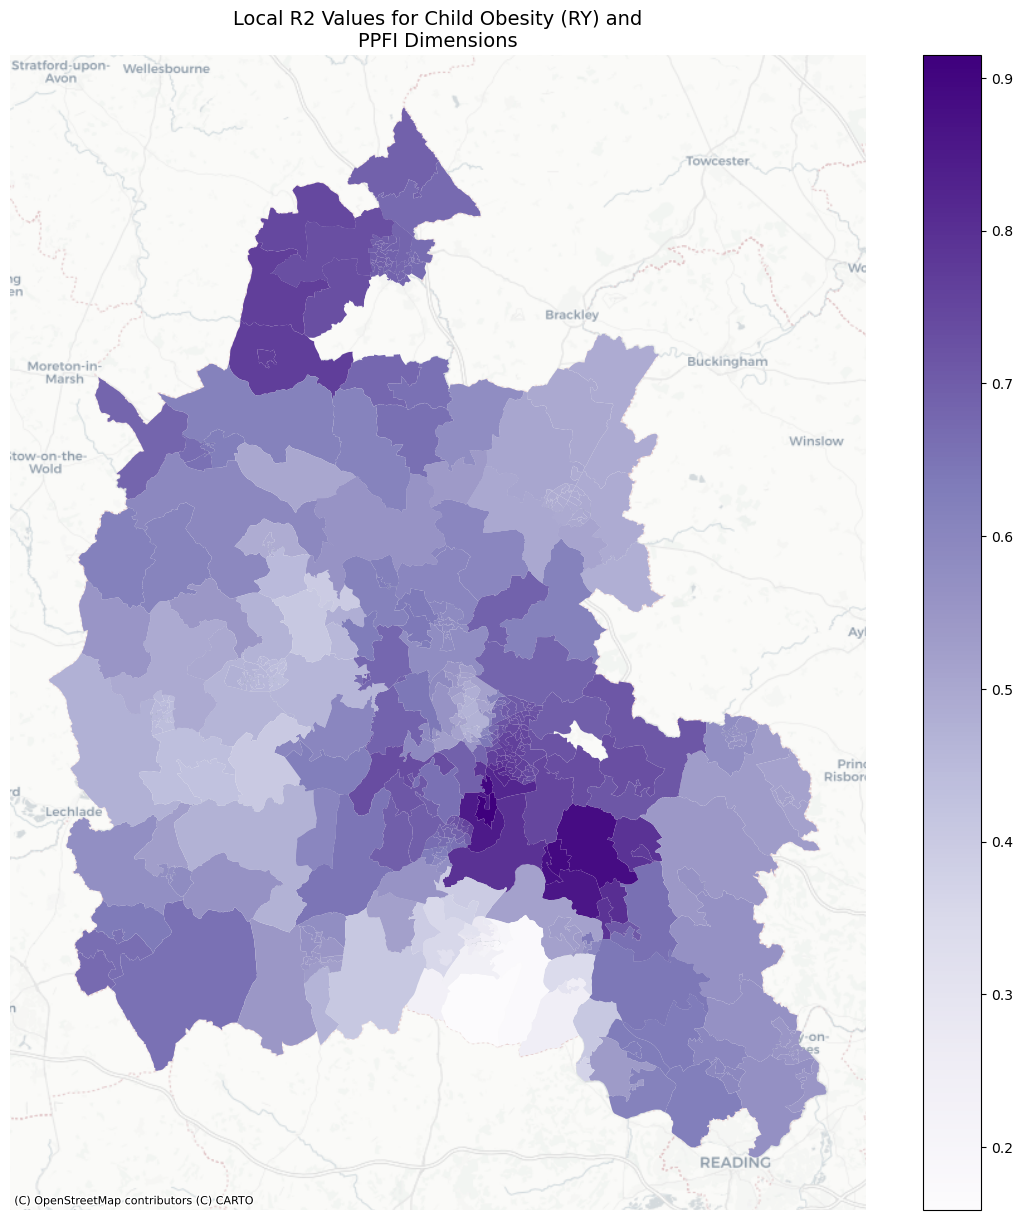

In [38]:
# plot the R2 values
ppfi_Ox_Reordered['R2'] = gwr_results.localR2

# define custom color map for R2
vmin = ppfi_Ox_Reordered['R2'].min()
vmax = ppfi_Ox_Reordered['R2'].max()
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)

fig,ax = plt.subplots(figsize=(15,15))
ppfi_Ox_Reordered.to_crs('EPSG:3857').plot(ax=ax, column='R2', legend=True, cmap='Purples', norm=norm)
plt.axis('off')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
title = 'Local R2 Values for Child Obesity (RY) and PPFI Dimensions'
wrapped_title = '\n'.join(textwrap.wrap(title,45))
plt.title(wrapped_title, fontsize=14)
plt.show()

### View the average R-squared values by district

In [39]:
ppfi_Ox_Reordered[['District','R2']].groupby('District').mean().reset_index()

District        R2
0             Cherwell  0.604144
1               Oxford  0.664342
2    South Oxfordshire  0.518821
3  Vale of White Horse  0.597550
4     West Oxfordshire  0.513017

### Explore the coefficient estimates by creating a dataframe containing all the values

In [40]:
# Create a table for the Model coefficients and intercept values
model_parameters_ObesityRY = pd.DataFrame(gwr_results.params, 
                               columns = ['Intercept','Supermarket Proximity', 
                                          'Supermarket Accessibility','Non-Supermarket Proximity',
                                          'Fuel Poverty','Socio-demographic Barriers',
                                          'Food Support for Families',
                                          'E-Commerce Access']
                               )

# add the geometry and LSOA columns to the model parameters dataframe
model_parameters_ObesityRY = model_parameters_ObesityRY.assign(LSOA11CD = ppfi_Ox_Reordered['LSOA11CD'])
model_parameters_ObesityRY = model_parameters_ObesityRY.assign(LSOA11NM = ppfi_Ox_Reordered['LSOA11NM'])
model_parameters_ObesityRY = model_parameters_ObesityRY.assign(geometry = ppfi_Ox_Reordered['geometry'])
model_parameters_ObesityRY = model_parameters_ObesityRY.assign(localR2 = ppfi_Ox_Reordered['R2'])
model_parameters_ObesityRY = model_parameters_ObesityRY.assign(District = ppfi_Ox_Reordered['District'])

### Create a summary of the model parameters for each of the five districts

In [41]:
Districts_modelParams = model_parameters_ObesityRY[['Intercept', 'Supermarket Proximity', 'Supermarket Accessibility',
       'Non-Supermarket Proximity', 'Fuel Poverty',
       'Socio-demographic Barriers', 'Food Support for Families',
       'E-Commerce Access','District']].groupby('District').agg(['mean','median'])

Districts_modelParams.to_excel("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Child Obesity (Reception Year)/Oxfordshire/GWR with Child Obesity (Reception Year).xlsx",
                              sheet_name = "Model 2 District-Level Summary")

### Convert the created dataframe to a GeoPandas one for creating maps

In [42]:
model_parameters_ObesityRY = gpd.GeoDataFrame(model_parameters_ObesityRY, geometry='geometry')

### Generate maps for the estimated coefficients

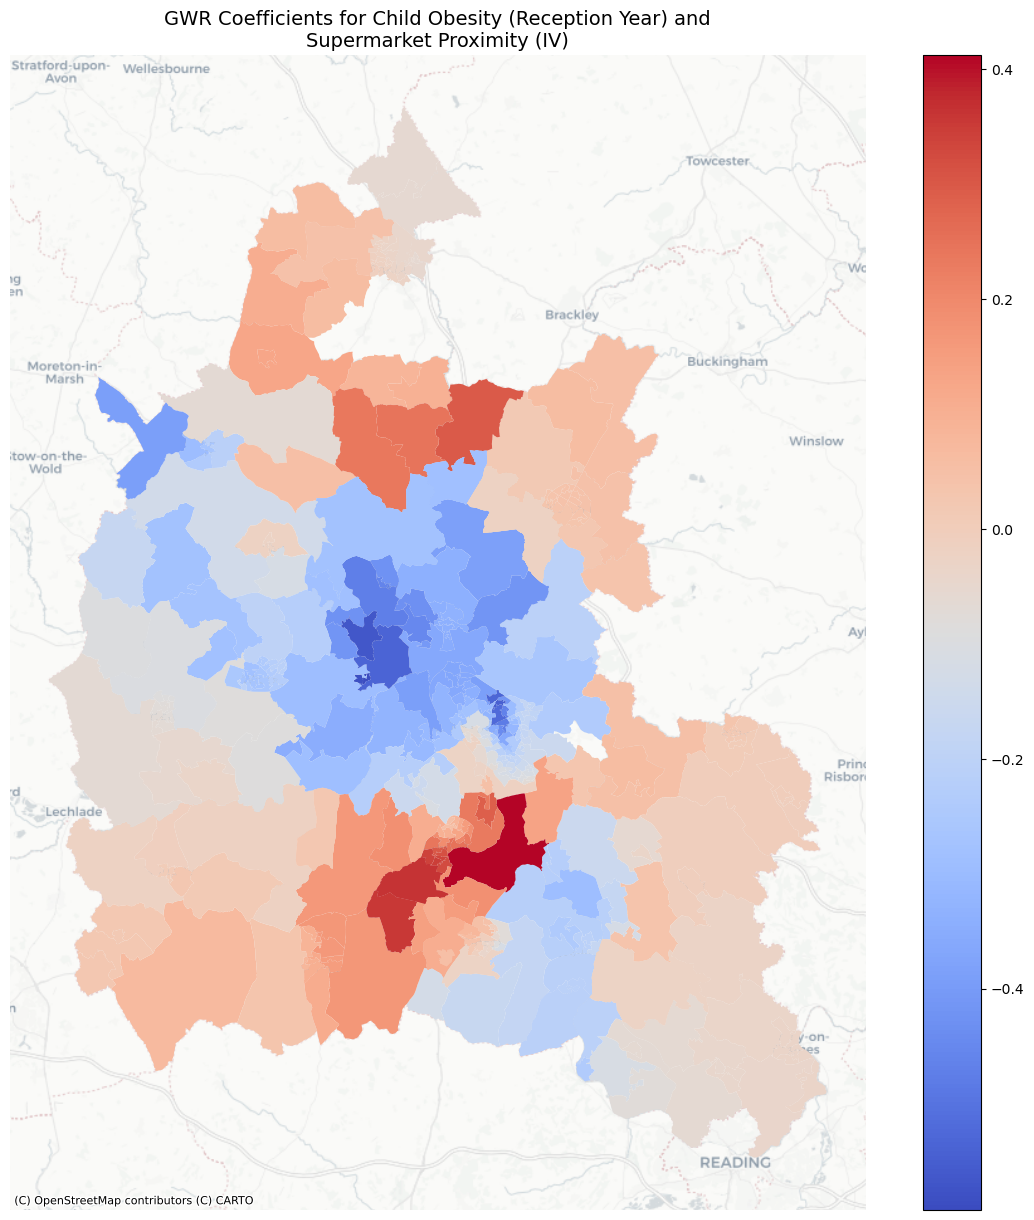

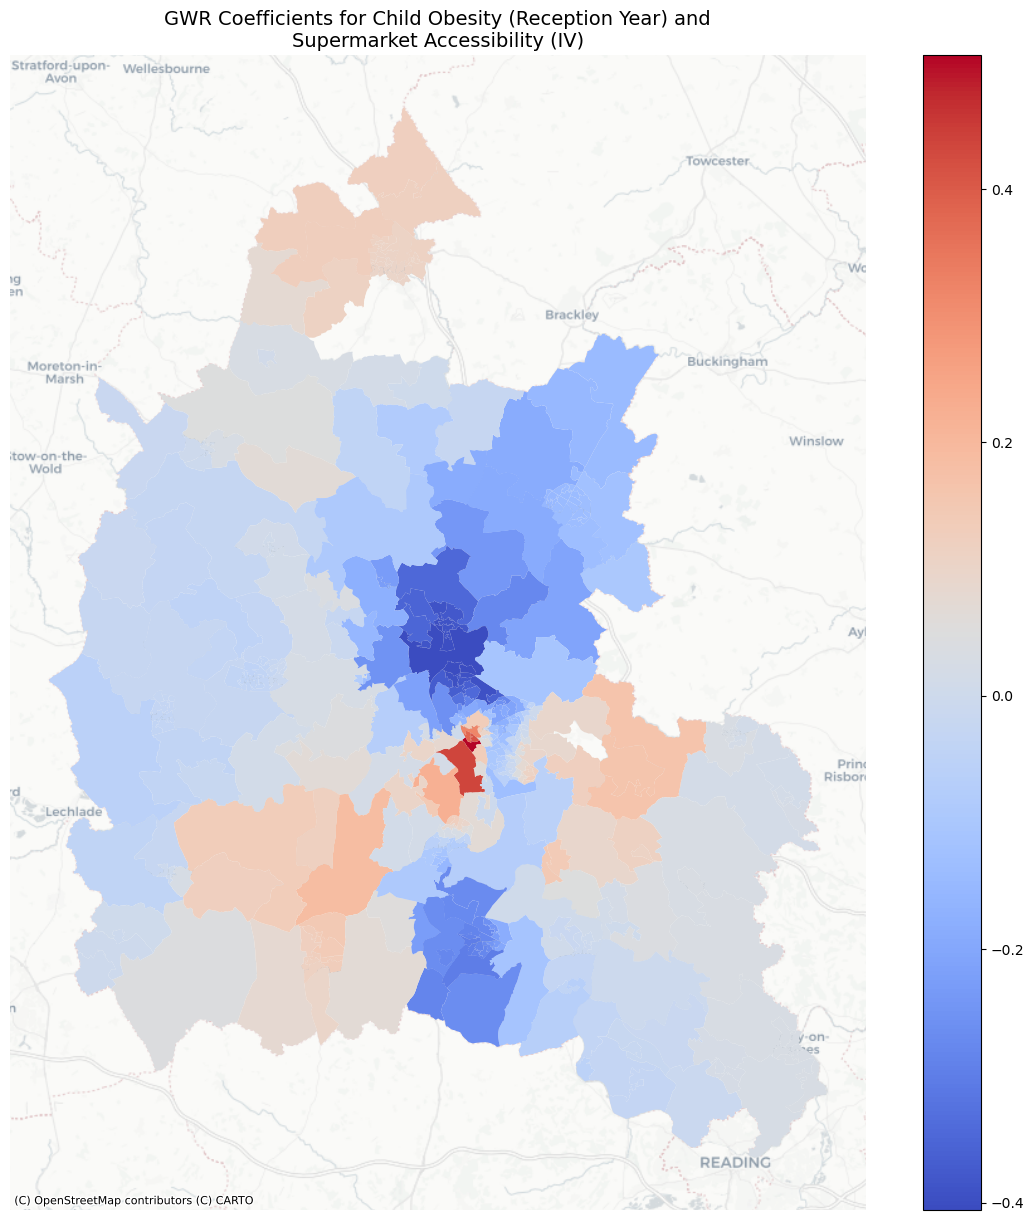

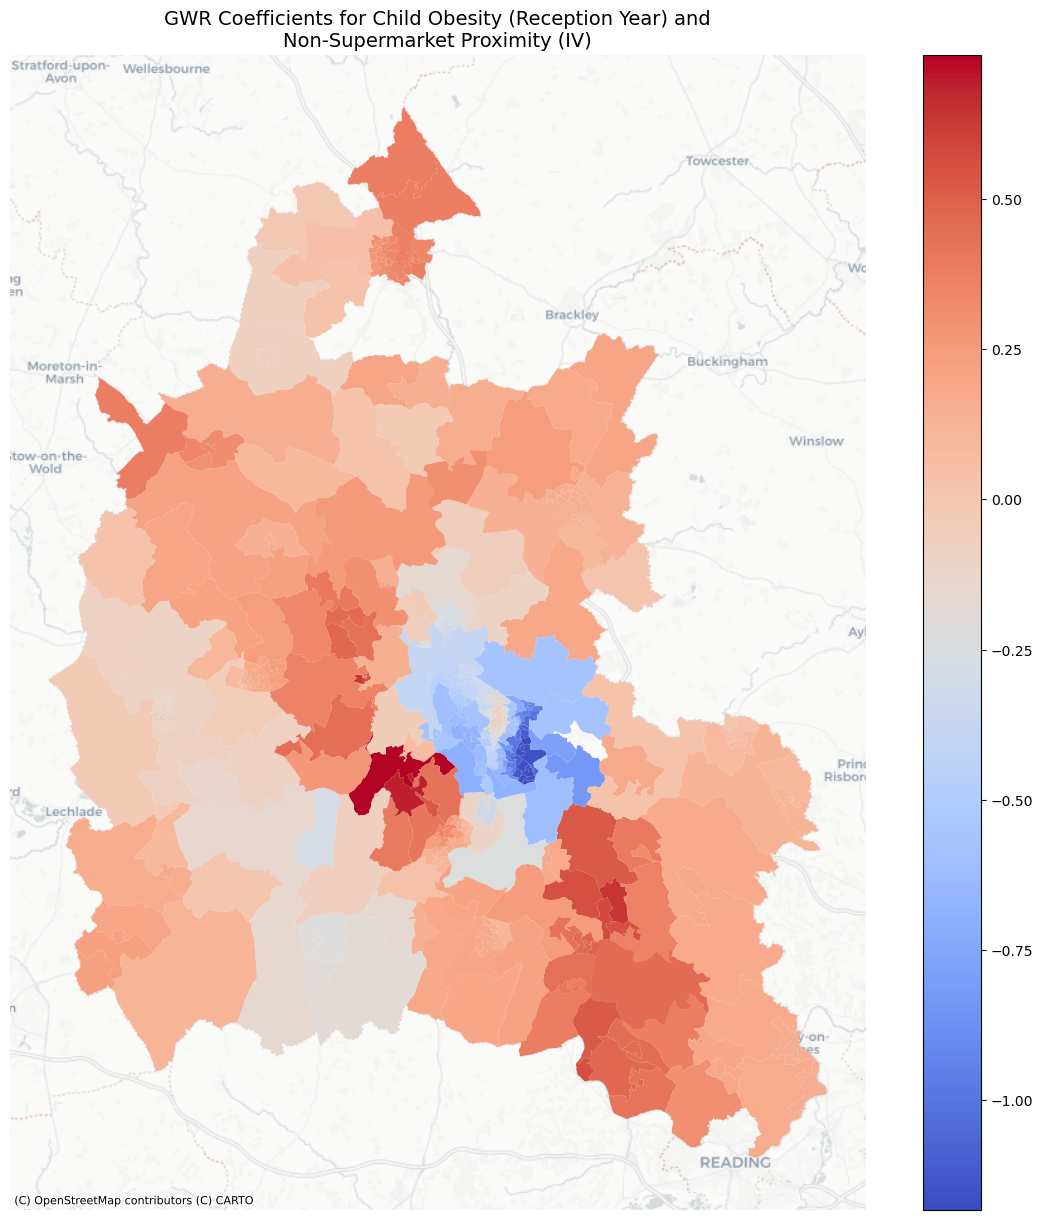

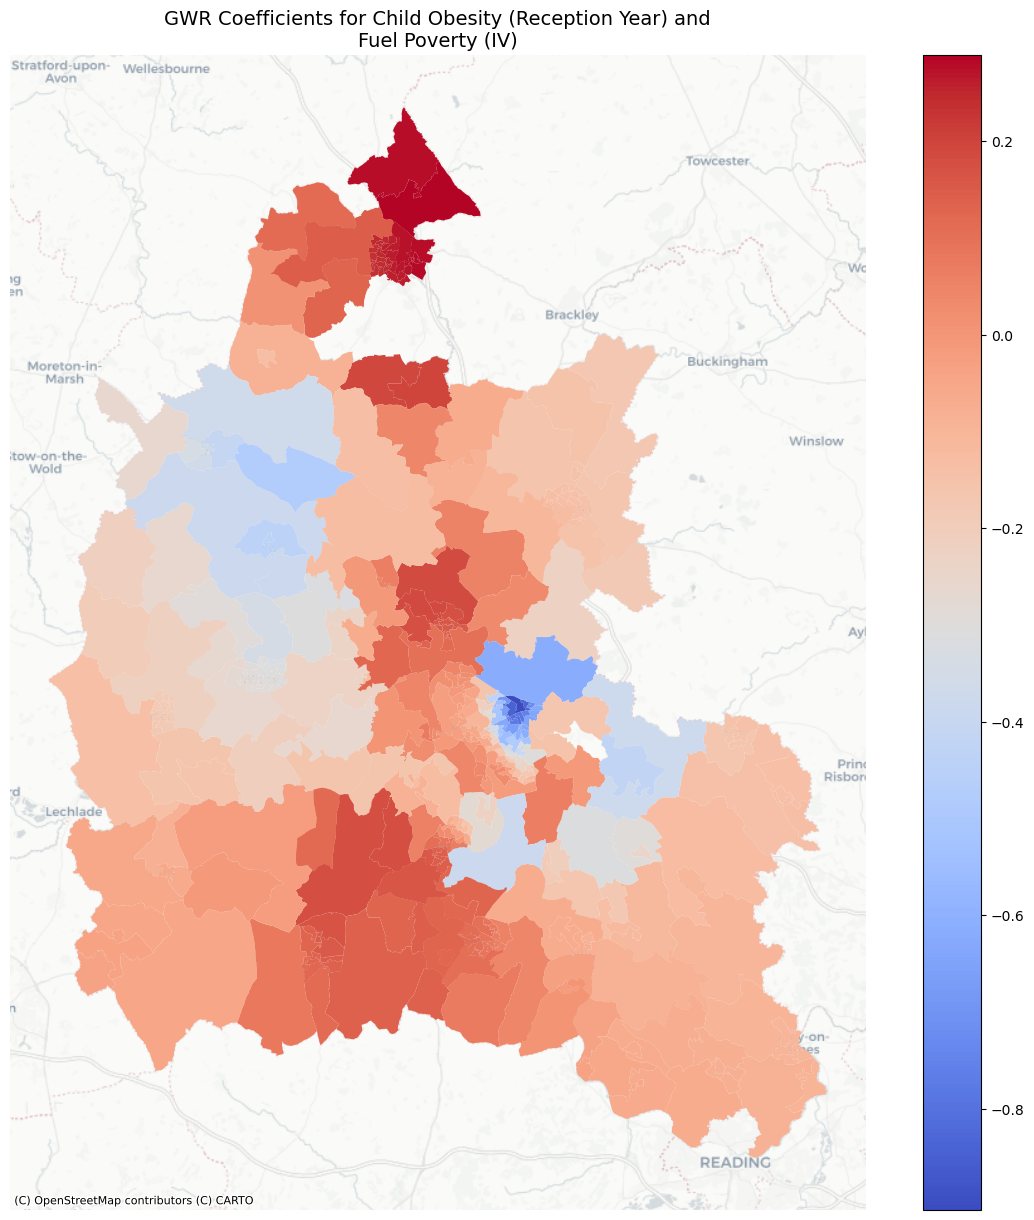

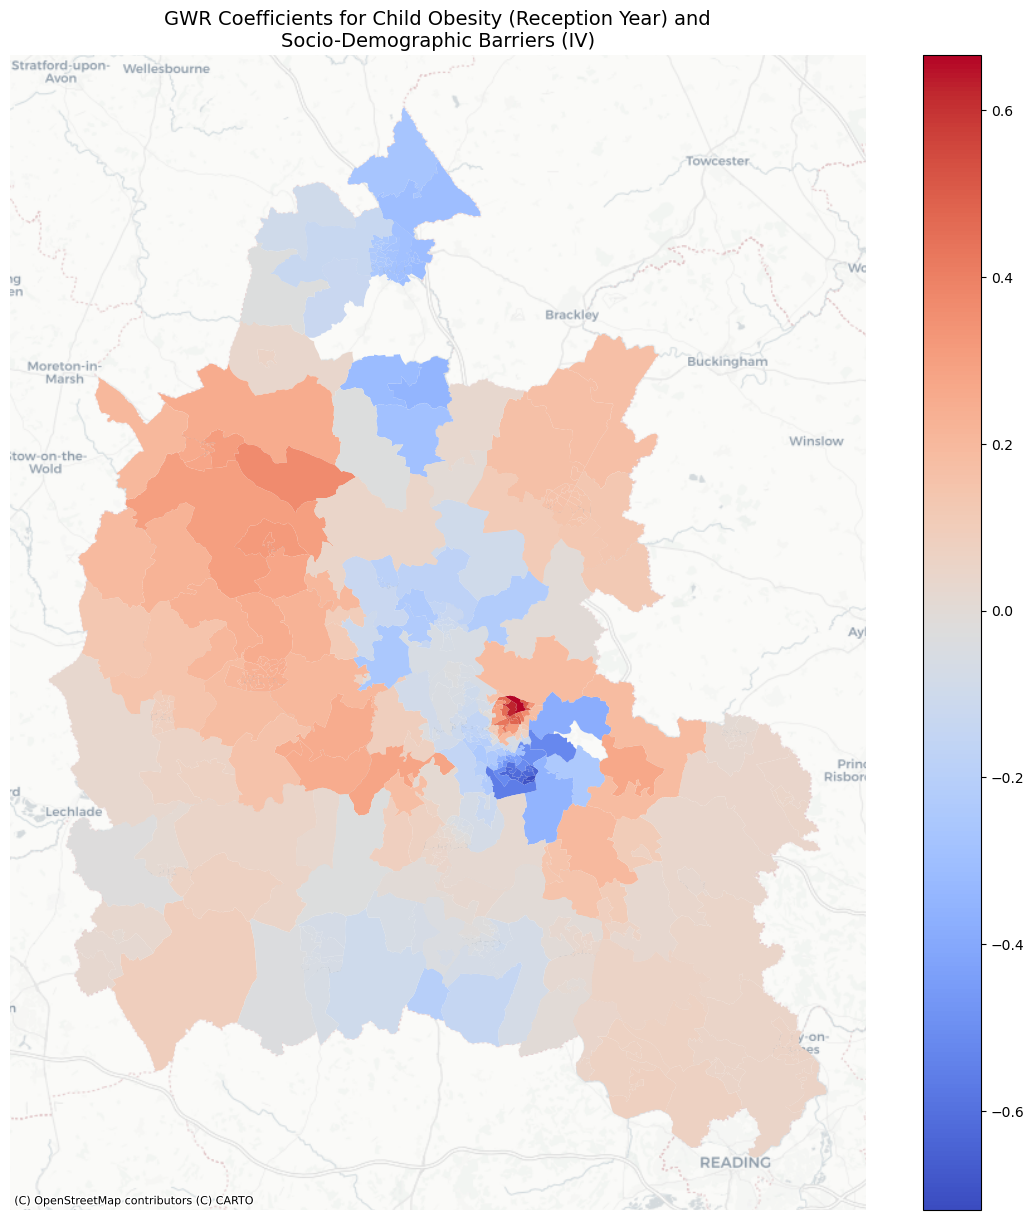

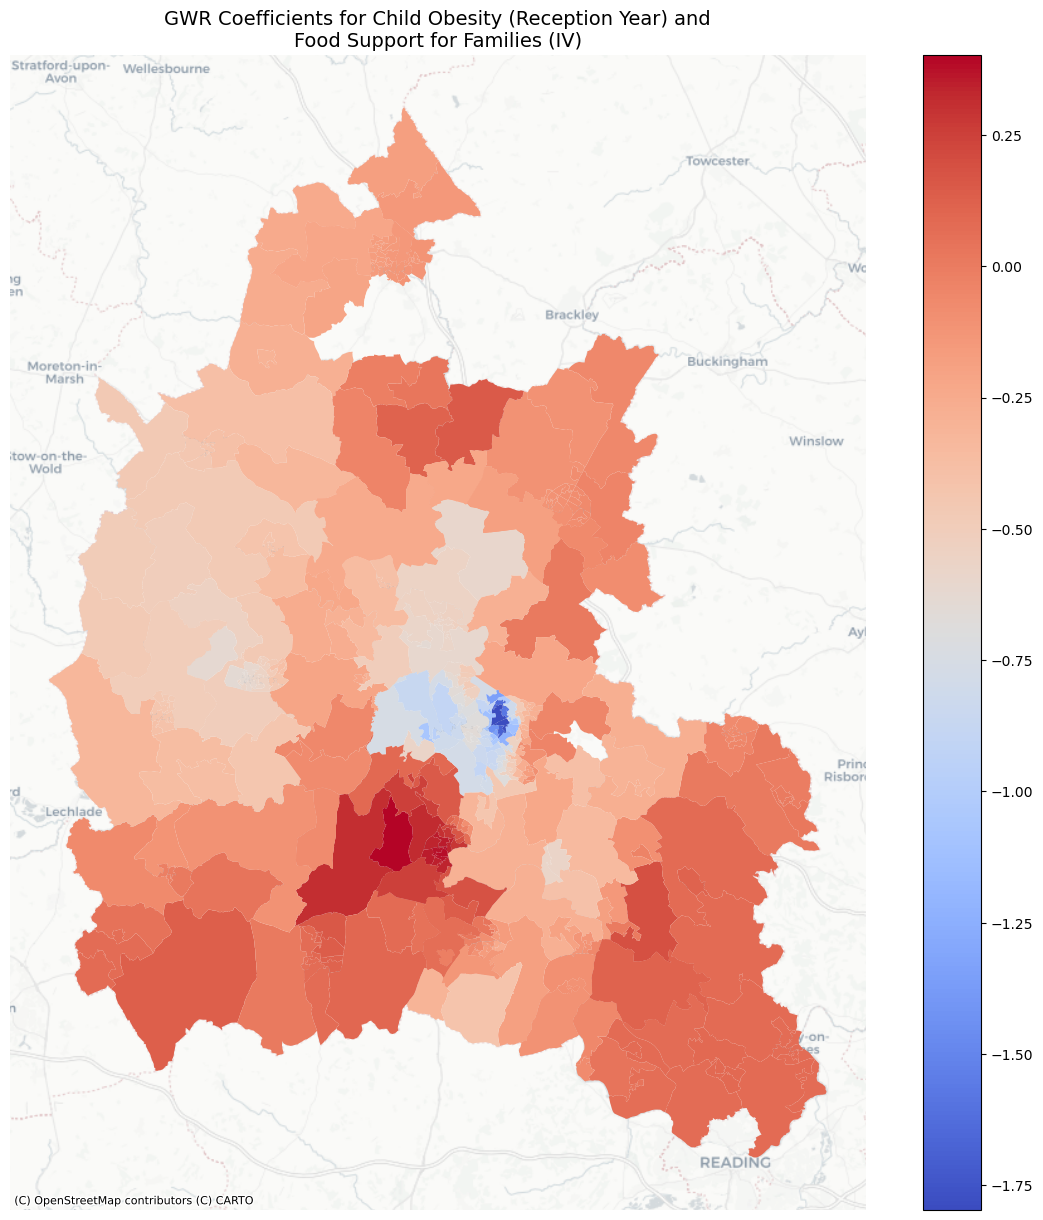

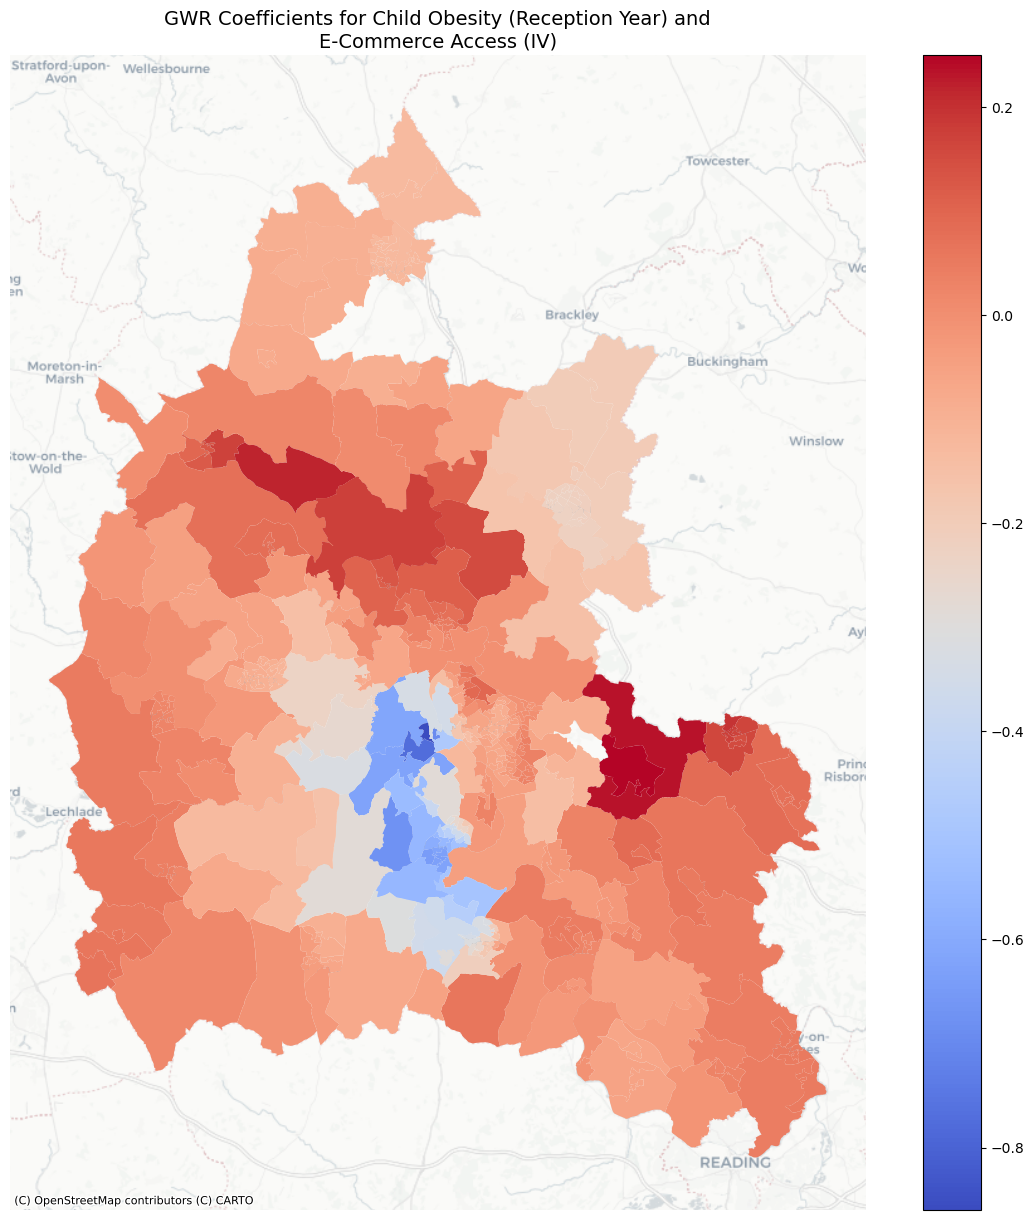

In [43]:
cols = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
       'E-Commerce Access']
titles = ['Supermarket Proximity', 'Supermarket Accessibility', 'Non-Supermarket Proximity', 'Fuel Poverty',
         'Socio-Demographic Barriers','Food Support for Families', 'E-Commerce Access']

for i,col,title in zip(range(len(cols)),cols,titles):
    fig,ax = plt.subplots(figsize=(15,15))
    
    # define custom color map for the coefficients
    vmin = model_parameters_ObesityRY[col].min()
    vmax = model_parameters_ObesityRY[col].max()
    norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)
    
    model_parameters_ObesityRY.to_crs('EPSG:3857').plot(ax=ax, column=col, legend=True, cmap='coolwarm',
                                                        norm=norm)
    title = f"GWR Coefficients for Child Obesity (Reception Year) and {title} (IV)"
    wrapped_title = '\n'.join(textwrap.wrap(title,55))
    plt.title(wrapped_title, fontsize=14)
    ax.set_axis_off()
    ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
    plt.show()

### Define a color map for the significant coefficient estimates

In [44]:
# define a color map, with white at zero
vmin = -2
vmax = 1
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap="RdBu_r"

## Explore Model Diagnostics

### Check the summary of the model results

In [45]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 414
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            934.618
Log-likelihood:                                                    -755.995
AIC:                                                               1527.990
AICc:                                                              1530.435
BIC:                                                              -1511.884
R2:                                                                   0.267
Adj. R2:                                                              0.255

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Generate a statistical summary of the model results

In [46]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
            'Fuel Poverty','Socio-Demographic Barriers','Family Food Support','E-Commerce Access']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(8):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the Parameters Summary to an Excel file

In [47]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Child Obesity (Reception Year)/Oxfordshire/GWR with Child Obesity (Reception Year).xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 2 Parameters Summary")


### Define a formatting style for the plots to come

In [48]:
kwargs = {'edgecolor':'black',
         'linewidth':0.5
         }

### Visualizing the Statistical Significance of the Parameter Estimates

In [49]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# column names used to loop through and capture the model estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# loop through to capture the parameter estimates
for col,i in list(zip(columns_significance, range(1,8))):
    parameter_estimates[col] = gwr_results.params[:,i]
    parameter_estimates[col+"_t"] = filter_t[:,i]
    parameter_estimates[col+"_tc"] = filter_tc[:,i]

# add other useful columns 
parameter_estimates[['LSOA11CD','LSOA11NM','geometry','District']] = ppfi_Ox_Reordered[['LSOA11CD','LSOA11NM','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

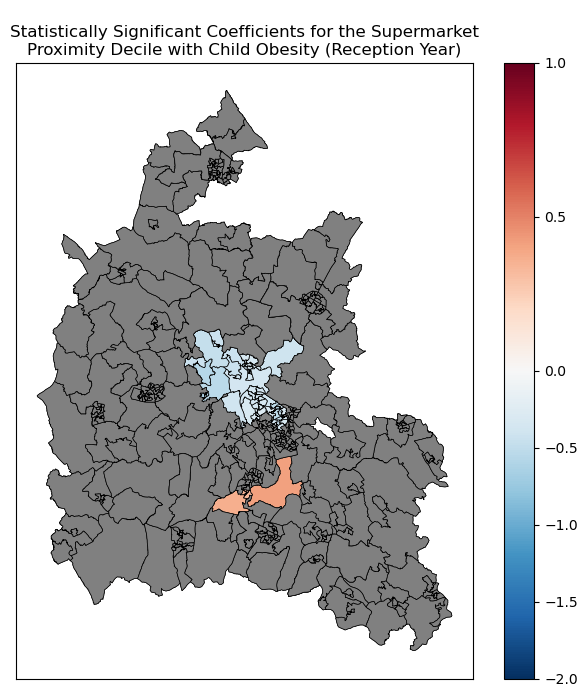

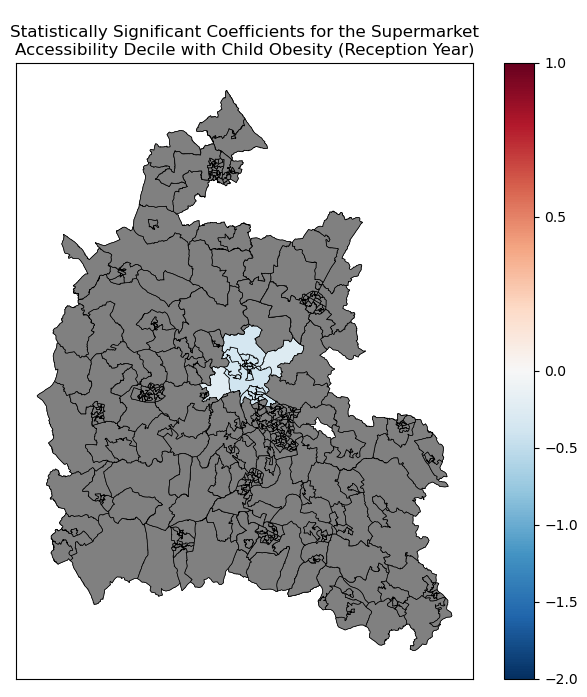

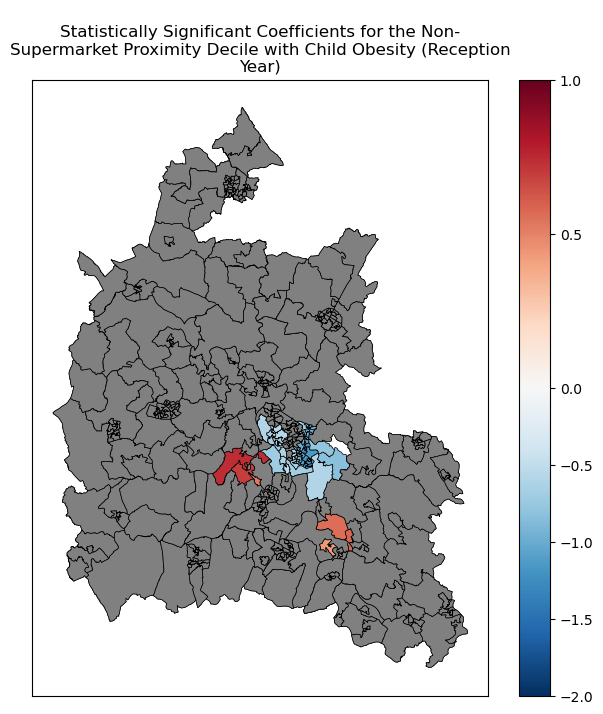

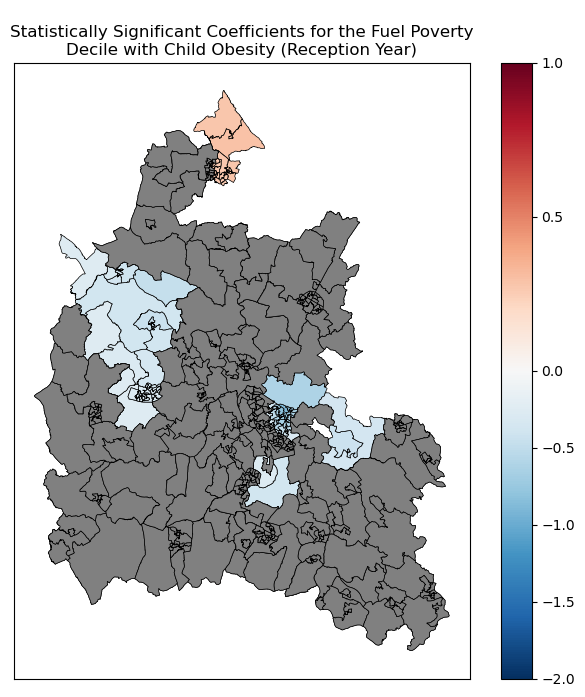

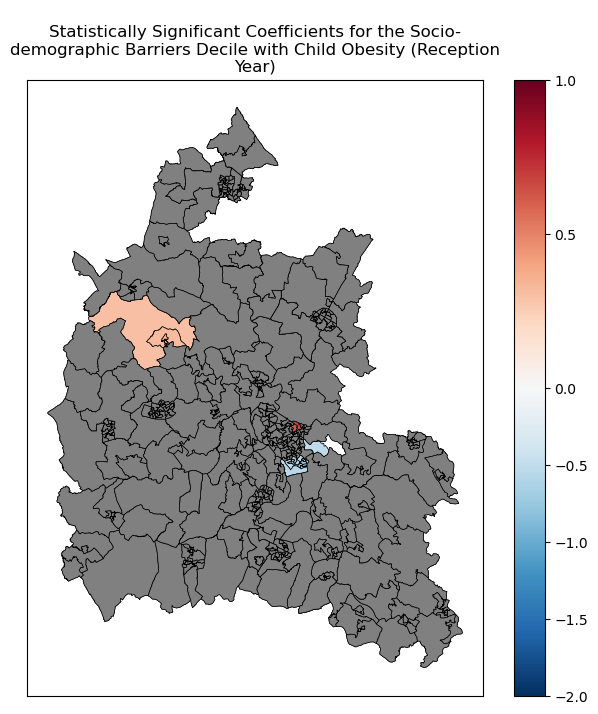

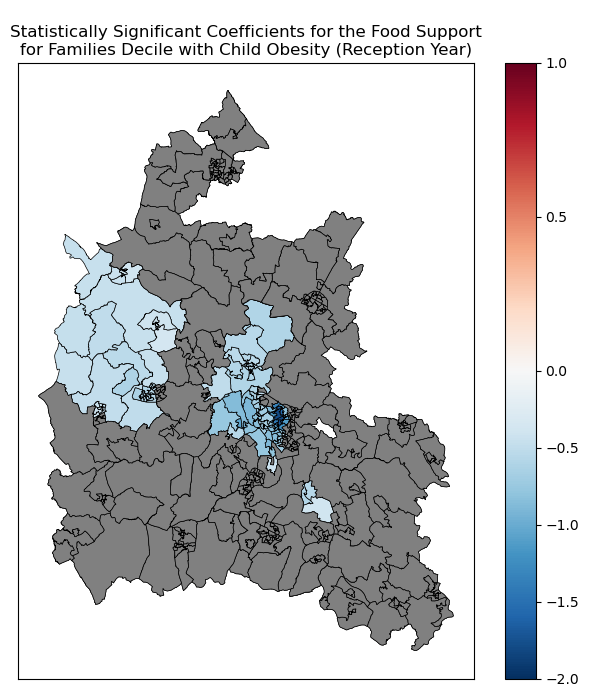

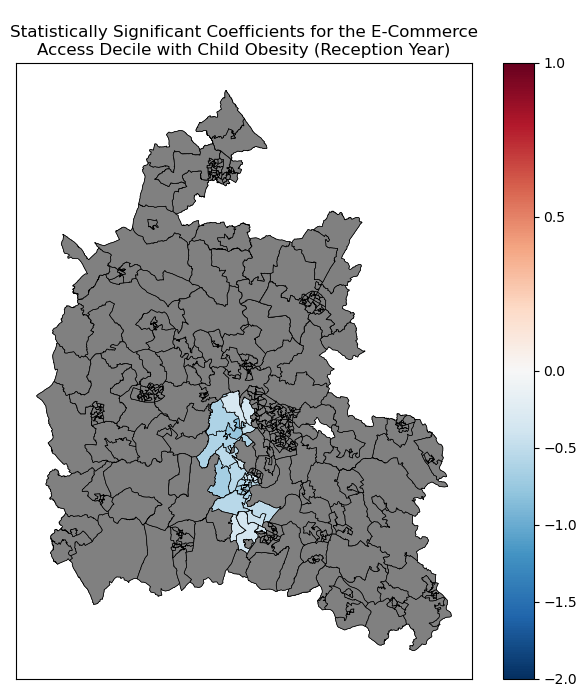

In [50]:
# define a list of column names used to generate the maps
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# define a list of dimension names to used to set titles for the maps
title_dimensions = ['Supermarket Proximity',
                   'Supermarket Accessibility',
                   'Non-Supermarket Proximity',
                   'Fuel Poverty',
                   'Socio-demographic Barriers',
                    'Food Support for Families',
                   'E-Commerce Access']

# create the maps
for col,title in list(zip(columns_significance,title_dimensions)):
    fig,ax = plt.subplots(figsize=(8,8))
    parameter_estimates.plot(
    col,
    ax=ax,
    legend=True,
    cmap=cmap,
    norm=norm,
    **kwargs
    )
    parameter_estimates[parameter_estimates[col+'_tc'] == 0].plot(ax=ax,
                                                                 color='grey',
                                                                 **kwargs)
    title = f"Statistically Significant Coefficients for the {title} Decile with Child Obesity (Reception Year)"
    ax.set_title("\n".join(textwrap.wrap(title,60)))                                                             
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [51]:
# define a list of dimensions names used to capture the parameter estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# define a list for the sheet names used when exporting the outputs to excel
sheet_names = ['SM_Prox','SM_Acc','NonSM_Prox','FuelPov','SD','FFF','E_Comm']

# define a dictionnary showing the district names and the total LSOAs (2011) count of each to add that 
# to the district summaries
LSOAs_Count = {
    "Cherwell":102,
    "South Oxfordshire":93,
    "West Oxfordshire":68,
    "Vale of White Horse":81,
    "Oxford":85
}

# list of statistical measures
lst = ['Mean','Median','LSOA_Count','Minimum','Maximum']

# create the statistical summary
for col,sheet_name in zip(columns_significance,sheet_names):
    district_estimates = parameter_estimates[parameter_estimates[col+"_tc"] !=0].groupby('District').agg(
        LSOA_Count=('LSOA11CD','nunique'),
        Mean=(col,'mean'),
        Median = (col,'median'),
        Minimum = (col,'min'),
        Maximum = (col,'max'),
    ).reset_index()
    district_estimates['Total_LSOAs'] = district_estimates['District'].map(LSOAs_Count)
    district_estimates['LSOA_Coverage'] = round(district_estimates['LSOA_Count']/district_estimates['Total_LSOAs']*100,2)
    district_estimates[lst] = district_estimates[lst].round(3)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Child Obesity (Reception Year)/Oxfordshire/GWR with Child Obesity (Reception Year).xlsx",
                   engine="openpyxl", mode="a") as writer:
        district_estimates.to_excel(writer, sheet_name = f"Summary_{sheet_name}")

### Get the significant LSOAs list for each District and Dimension

In [52]:
# loop through and export the outputs to excel
for col,sheet_name in zip(columns_significance,sheet_names):
    Sig_LSOA_list = parameter_estimates[parameter_estimates[col+"_tc"] != 0].round(3)
    Sig_LSOA_list = Sig_LSOA_list[['LSOA11CD','District',col]].merge(Ox_dem[['LSOA11CD','LSOA21CD','LSOA21NM','RUC11']], 
                                                                             on='LSOA11CD',how='inner').reset_index()
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Child Obesity (Reception Year)/Oxfordshire/GWR with Child Obesity (Reception Year).xlsx",
                   engine="openpyxl", mode="a") as writer:
        Sig_LSOA_list.to_excel(writer, sheet_name = f"Sig_{sheet_name}")

### Group the district-level estimates of LSOAs by the RUC classification

In [53]:
# create a dictionnary of the Cherwell LSOAs count by RUC classification 
District_RUC_LSOA_Count = {
    "Cherwell":{
        "Urban city and town": 69,
        "Rural village and dispersed": 26,
        "Rural town and fringe": 7
    },
    "South Oxfordshire":{
        "Urban city and town": 49,
        "Rural village and dispersed": 21,
        "Rural town and fringe": 23
    },
    "West Oxfordshire":{
        "Urban city and town": 28,
        "Rural village and dispersed": 19,
        "Rural town and fringe": 21
    },
    "Oxford":{
        "Urban city and town": 84,
        "Rural village and dispersed": 0,
        "Rural town and fringe": 1
    },
    "Vale of White Horse":{
        "Urban city and town": 49,
        "Rural village and dispersed": 10,
        "Rural town and fringe": 22
    }
}

# define a function to get the LSOA count values from the dictionnary defined above
def get_value(row):
    return District_RUC_LSOA_Count[row["District"]][row['RUC11']]

# create the dataframe
for col,sheet_name in zip(columns_significance, sheet_names):
    Grouped_RUC = parameter_estimates[parameter_estimates[col+"_tc"] != 0]
    Grouped_RUC = Grouped_RUC[['LSOA11CD','District',col]].merge(Ox_dem[['LSOA11CD','RUC11']], on='LSOA11CD', how='inner')
    Grouped_RUC = Grouped_RUC.groupby(['District','RUC11']).agg(
        LSOA_Count = ('LSOA11CD','nunique'),
        Coeff_Average = (col,'mean')
    ).reset_index()
    Grouped_RUC['Total_LSOAs'] = Grouped_RUC.apply(get_value, axis=1)
    Grouped_RUC['Coeff_Average'] = round(Grouped_RUC['Coeff_Average'],3)
    Grouped_RUC['LSOA_Coverage'] = round(Grouped_RUC['LSOA_Count']/Grouped_RUC['Total_LSOAs']*100,2)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Child Obesity (Reception Year)/Oxfordshire/GWR with Child Obesity (Reception Year).xlsx",
                   engine="openpyxl", mode="a") as writer:
        Grouped_RUC.to_excel(writer, sheet_name = f"Sig_RUC_{sheet_name}")

## Fit a GWR model with the Prevalence of Child Obesity at the RY as the dependent variable and the PPFI combined decile as the independent variable

### Define the variables

In [54]:
# define the dependent variable as RY obesity levels
y = ppfi_Ox_Reordered['Obese Children (Reception Year)'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[['PPFI Combined Decile']].values

y = np.array(y)
X = np.array(X)

### Define the coordinates

In [55]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model and compute the optimal bandwidth

In [56]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

45.0


### Fit the model

In [57]:
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

### Get the results

In [58]:
gwr_results = gwr_model.fit()

### Get the global R-squared value

In [59]:
global_R2 = gwr_results.R2
print(global_R2)

0.5619334322235816


## Model Diagnostics

### View the statistical summary of the model results

In [60]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 414
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1096.038
Log-likelihood:                                                    -788.974
AIC:                                                               1581.948
AICc:                                                              1584.007
BIC:                                                              -1386.618
R2:                                                                   0.141
Adj. R2:                                                              0.139

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Create a statistical summary of the model parameters

In [61]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Combined Decile']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(2):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the statistical Summary to an Excel file

In [62]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Child Obesity (Reception Year)/Oxfordshire/GWR with Child Obesity (Reception Year).xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 1 Parameters Summary")

### Visualize the Statistical Significance of Parameter Estimates

In [63]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# capture the parameter estimates
parameter_estimates['PPFI Combined Decile'] = gwr_results.params[:,1]
parameter_estimates['PPFI Combined Decile_t'] = filter_t[:,1]
parameter_estimates['PPFI Combined Decile_tc'] = filter_tc[:,1]

# add other useful columns 
parameter_estimates[['LSOA11CD','LSOA11NM','geometry','District']] = ppfi_Ox_Reordered[['LSOA11CD','LSOA11NM','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

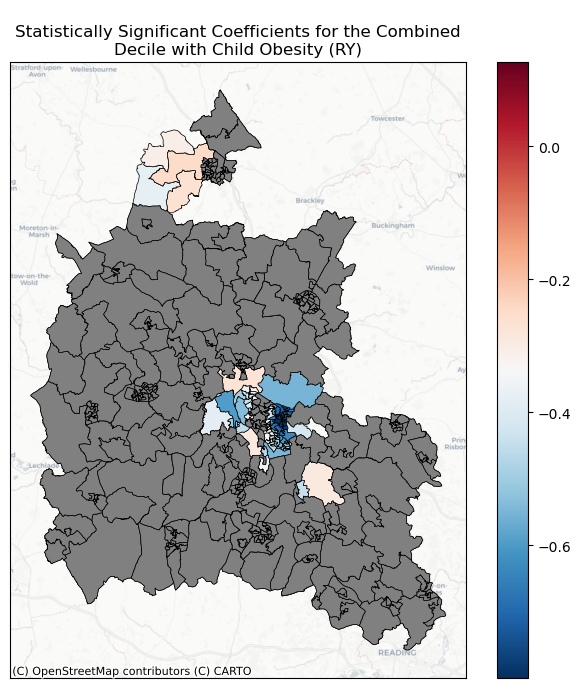

In [64]:
# generate the map of the statistically significant parameter estimates
fig,ax = plt.subplots(figsize=(8,8))

parameter_estimates.plot(
    'PPFI Combined Decile',
    ax=ax,
    legend=True,
    **kwargs,
    cmap=cmap
)

parameter_estimates[filter_tc[:,1] == 0].plot(ax=ax,
                                              color='grey',
                                            **kwargs
                                             )
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = f"Statistically Significant Coefficients for the Combined Decile with Child Obesity (RY)"
ax.set_title("\n".join(textwrap.wrap(title,60)))  
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)

plt.show()

In [65]:

district_estimates = parameter_estimates[filter_tc[:,1] !=0].groupby('District').agg(LSOA_Count = ('LSOA11CD','nunique'),
                                            Mean = ('PPFI Combined Decile','mean'),
                                            Median = ('PPFI Combined Decile','median'),
                                            Minimum = ('PPFI Combined Decile','min'),
                                            Maximum = ('PPFI Combined Decile','max')
                                                               ).reset_index()
LSOAs_Count = {
    "Cherwell":102,
    "South Oxfordshire":93,
    "West Oxfordshire":68,
    "Vale of White Horse":81,
    "Oxford":85
}
def get_value(row):
    return LSOAs_Count[row]
district_estimates['Total_LSOAs'] = district_estimates['District'].apply(get_value)
district_estimates['LSOA_Coverage'] = round(district_estimates['LSOA_Count']/district_estimates['Total_LSOAs']*100,3)
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/GWR with Child Obesity (Reception Year)/Oxfordshire/GWR with Child Obesity (Reception Year).xlsx",
                   engine="openpyxl", mode="a") as writer:
    district_estimates.to_excel(writer, sheet_name = "Model 1_Sig")

### Notes

In [66]:
ppfi_Ox_Reordered[['District','Obese Children (Reception Year)']].groupby('District').mean().reset_index()

District  Obese Children (Reception Year)
0             Cherwell                         7.741111
1               Oxford                         8.330588
2    South Oxfordshire                         6.613333
3  Vale of White Horse                         6.198765
4     West Oxfordshire                         6.880882

Model 1 results show that tackling overall food insecurity could contribute to reducing reception year child obesity in all Oxfordshire districts except West Oxfordshire. Moreover, statistical significance covers almost 73% of Oxford LSOAs.

#### Barriers to Food Purchase (Supermarket Proximity/Accessibility - E-commerce access - Non-supermarket proximity)

- Supermarket proximity as well as non-supermarket proximity are significant in Oxford with non-supermarket proximity cover more LSOAs and having a significantly higher magnitude. Therefore, in terms of Oxford barriers to food purchase, better non-supermarket proximity could have the most contribution towards reducing child obesity while supermarket accessibility and online deliveries may not contribute alot. 
- On the one hand, this could be a reflection of good supermarket accessibility in Oxford due to the reliability of public transport and the short distances as the district is small in surface area. At the same time, there could be some areas in Oxford where there adding more stores could be helpful towards tackling child obesity.
- In Oxford, supermarket and non-supermarket proximity could contribute the most to reducing child obesity prevalence rates.
- In parts of Cherwell, supermarket proximity and accessibility could contribute towards reducing child obesity prevalence rates. 
- In South Oxfordshire, tackling barriers to food purchases is not estimated to have a significant effect on child obesity prevalence rates in most of the district.
- In West Oxfordshire, we see significance for supermarket proximity and particularly in the areas classified as rural towns and villages. This reflects the need for more supermarkets in these rural areas.
- In Vale of White Horse, we see significance for the E-commerce access dimension thus reflecting the contribution that better acccess to online deliveries (and the promotions that come with it) could have towards reducing child obesity prevalence rates.

#### Poverty and Deprivation (Socio-demographic Barriers - Food support for families - fuel poverty)

- We also see high significance and magnitude of coefficients for fuel poverty in parts of Oxford. This could be down to the higher costs of living in some of these areas which forces families to sacrifice their food budget in order to keep their homes warm. 
- West Oxfordshire also has significant and negative coefficients for fuel poverty.
- Socio-demographic barriers aren't expected to be a major contributor towards child obesity in Oxfordshire.
- In terms of food support, we see the most significance and LSOA coverage in Oxford and West Oxfordshire.
- In Oxford, all three dimensions in relation to poverty and deprivation could contribute to reducing child obesity prevalence rates. However, the most notable dimension is the food support for families one and it possible that the high population density in Oxford drives the high demand for food support. 
- There is significance for food support and fuel poverty in West Oxfordshire with a high LSOA coverage for the urban as well as rural areas. There are many common areas in West Oxfordshire where coefficients for fuel poverty and food support are significant and this indicates that
- In Vale of White Horse, we see significance for the food support dimension and particularly in the areas classified as urban.
- Poverty and deprivation is not estimated to have a significant contribution towards reducing child obesity prevalence rates in most South Oxfordshire LSOAs. 
- In Cherwell, the only dimension under poverty and deprivation which is expected to contribute towards reducing child obesity prevalence rates is food support.